In [1]:
import pandas as pd
import os

# 文件路径
basicincident_file = os.path.join('DATA_nfirs2000-2021/NFIRS2021/basicincident.txt')
processed_csv_file = os.path.join('morans_data/2021/basicincident_processed_2021.csv')

# 处理并转换日期时间格式的函数
def convert_datetime(dt_str):
    return pd.to_datetime(dt_str, format='%m%d%Y%H%M', errors='coerce')

# 处理basicincident.txt文件
def process_basicincident(file_path):
    chunk_size = 10000  # 每次读取的行数
    chunks = []
    total_rows = 0  # 记录总行数
    ca_rows = 0  # 记录CA行数

    for chunk in pd.read_csv(file_path, delimiter='^', encoding='latin1', low_memory=False, chunksize=chunk_size):
        total_rows += len(chunk)
        # 过滤出加利福尼亚州的数据
        chunk_ca = chunk[chunk['STATE'] == 'CA']
        ca_rows += len(chunk_ca)

        # 转换日期和时间格式
        chunk_ca['ALARM'] = chunk_ca['ALARM'].apply(convert_datetime)
        chunk_ca['ARRIVAL'] = chunk_ca['ARRIVAL'].apply(convert_datetime)
        chunk_ca['LU_CLEAR'] = chunk_ca['LU_CLEAR'].apply(convert_datetime)

        # 确保列转换为日期时间类型
        if not pd.api.types.is_datetime64_any_dtype(chunk_ca['ALARM']):
            chunk_ca['ALARM'] = pd.to_datetime(chunk_ca['ALARM'], errors='coerce')
        if not pd.api.types.is_datetime64_any_dtype(chunk_ca['ARRIVAL']):
            chunk_ca['ARRIVAL'] = pd.to_datetime(chunk_ca['ARRIVAL'], errors='coerce')
        if not pd.api.types.is_datetime64_any_dtype(chunk_ca['LU_CLEAR']):
            chunk_ca['LU_CLEAR'] = pd.to_datetime(chunk_ca['LU_CLEAR'], errors='coerce')

        # 丢弃ALARM和ARRIVAL中为空的行
        chunk_ca = chunk_ca.dropna(subset=['ALARM', 'ARRIVAL'])

        # 计算响应时间和解决火灾的时间
        chunk_ca['RESPONSE_TIME'] = (chunk_ca['ARRIVAL'] - chunk_ca['ALARM']).dt.total_seconds() / 60  # 以分钟为单位
        chunk_ca['FIRE_CLEARANCE_TIME'] = (chunk_ca['LU_CLEAR'] - chunk_ca['ARRIVAL']).dt.total_seconds() / 60  # 以分钟为单位

        chunks.append(chunk_ca)

    # 合并所有处理后的数据块
    processed_df = pd.concat(chunks, ignore_index=True)
    
    # 保存为CSV文件
    processed_df.to_csv(processed_csv_file, index=False)
    print(f"Processed data saved to {processed_csv_file}")
    print(f"Total rows: {total_rows}, CA rows: {ca_rows}")

    # 输出前几行查看结果
    print(processed_df)

# 运行处理函数
process_basicincident(basicincident_file)


/tmp/ipykernel_142/2315449172.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_ca['ALARM'] = chunk_ca['ALARM'].apply(convert_datetime)
/tmp/ipykernel_142/2315449172.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_ca['ARRIVAL'] = chunk_ca['ARRIVAL'].apply(convert_datetime)
/tmp/ipykernel_142/2315449172.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Processed data saved to morans_data/2021/basicincident_processed_2021.csv
Total rows: 2109645, CA rows: 200274
                       INCIDENT_KEY STATE   FDID  INC_DATE   INC_NO  EXP_NO  \
0       CA_01005_01032021_2100052_0    CA   1005   1032021  2100052       0   
1       CA_01005_01062021_2100129_0    CA   1005   1062021  2100129       0   
2       CA_01005_01092021_2100194_0    CA   1005   1092021  2100194       0   
3       CA_01005_01132021_2100254_0    CA   1005   1132021  2100254       0   
4       CA_01005_01132021_2100275_0    CA   1005   1132021  2100275       0   
...                             ...   ...    ...       ...      ...     ...   
195411  CA_58555_10092021_0026845_0    CA  58555  10092021    26845       0   
195412  CA_58555_10092021_0026848_0    CA  58555  10092021    26848       0   
195413  CA_58555_10112021_0027108_0    CA  58555  10112021    27108       0   
195414  CA_58555_10142021_0027349_0    CA  58555  10142021    27349       0   
195415  CA_58555_111

In [2]:
import pandas as pd
import geopandas as gpd

# 文件路径
processed_csv_file = 'morans_data/2021/basicincident_processed_2021.csv'
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
output_file = 'morans_data/2021/filtered_fire_data_2021.csv'

# 读取 shapefile 数据
gdf = gpd.read_file(shapefile_path)

# 确保 FDID 列为字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 空列表存储分块处理后的数据
chunks = []
chunk_size = 10000  # 每次处理的行数

# 分块读取火灾数据并过滤加利福尼亚州的数据
dtypes = {
    'FDID': str,
    'STATE': str,
    'RESPONSE_TIME': float,
    'FIRE_CLEARANCE_TIME': float,
    'ALARM': str,
    'ARRIVAL': str,
    'LU_CLEAR': str
}

for chunk in pd.read_csv(processed_csv_file, chunksize=chunk_size, dtype=dtypes, low_memory=False):
    chunk_ca = chunk[chunk['STATE'] == 'CA']
    chunks.append(chunk_ca[['FDID', 'RESPONSE_TIME', 'FIRE_CLEARANCE_TIME']])

# 合并所有分块
fire_data_ca = pd.concat(chunks)

# 保存处理后的数据
fire_data_ca.to_csv(output_file, index=False)
print(f"Filtered data saved to {output_file}")


Filtered data saved to morans_data/2021/filtered_fire_data_2021.csv


In [3]:
import dask.dataframe as dd
import geopandas as gpd
from libpysal.weights import Queen
from esda.moran import Moran
from scipy.sparse import csr_matrix
import numpy as np

# 文件路径
filtered_data_file = 'morans_data/2021/filtered_fire_data_2021.csv'
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'

# 读取过滤后的火灾数据
fire_data_ca = dd.read_csv(filtered_data_file)

# 读取 shapefile 数据
gdf = gpd.read_file(shapefile_path)

# 确保火灾数据中的 FDID 列为字符串类型
fire_data_ca['FDID'] = fire_data_ca['FDID'].astype(str)
gdf['FDID'] = gdf['FDID'].astype(str)

# 将 fire_data_ca 转换为 pandas DataFrame
fire_data_ca = fire_data_ca.compute()

# 合并数据并仅保留必要的列
merged = gdf[['FDID', 'geometry']].merge(fire_data_ca[['FDID', 'RESPONSE_TIME', 'FIRE_CLEARANCE_TIME']], on='FDID', how='inner')

# 检查合并后的数据大小
print(f"Size of merged data: {merged.shape}")

# 检查合并后的数据
print(merged.head())


/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopython' keyw

Size of merged data: (166503, 4)
    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   
1  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            6.0   
2  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   
3  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   
4  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   

   FIRE_CLEARANCE_TIME  
0                 30.0  
1                  4.0  
2                 17.0  
3                 14.0  
4                  7.0  


In [1]:
import geopandas as gpd

# 读取 Shapefile 数据
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中的 FDID 列为字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 检查读取的数据
print(gdf.head())


    County   FDID MACSID                               Name  \
0  ALAMEDA    nan    NaN               CAMP PARKS FIRE DEPT   
1  ALAMEDA    nan    NaN  FAIRVIEW FIRE PROTECTION DISTRICT   
2  ALAMEDA  01005    ALA                         ALAMEDA FD   
3  ALAMEDA  01008    ACF                  ALAMEDA COUNTY FD   
4  ALAMEDA  01010    ALB                  CITY OF ALBANY FD   

              Address     City    Zip            FireChief           Phone  \
0                 NaN      NaN    NaN                  NaN             NaN   
1                 NaN      NaN    NaN                  NaN  (510) 583-4940   
2        1300 PARK ST  ALAMEDA  94501        NICHOLAS LUBY  (510) 337-2100   
3      6363 CLARK AVE   DUBLIN  94568  WILLIAM L. MCDONALD  (925) 833-3473   
4  1000 SAN PABLO AVE   ALBANY  94706          JAMES BOITO  (510) 528-5770   

  Notes  LastUpdate                                            Website  \
0   NaN  2018-06-21                                             <Null>   
1   

In [2]:
import pandas as pd

# 定义一个处理数据块的函数
def process_chunk(chunk):
    chunk['FDID'] = chunk['FDID'].astype(str)

    # 仅保留必要的列
    chunk = chunk[['FDID', 'RESPONSE_TIME', 'FIRE_CLEARANCE_TIME']]
    
    # 合并数据
    merged_chunk = gdf[['FDID', 'geometry']].merge(chunk, on='FDID', how='inner')
    return merged_chunk


In [3]:
import os

# 文件路径
filtered_data_file = 'morans_data/2021/filtered_fire_data_2021.csv'
merged_data_file = 'morans_data/2021/merged_fire_data_2021.csv'

# 初始化保存合并结果
first_chunk = True
chunk_size = 10000  # 根据需要调整块大小

# 分块读取火灾数据并处理
for chunk in pd.read_csv(filtered_data_file, chunksize=chunk_size):
    processed_chunk = process_chunk(chunk)
    if first_chunk:
        processed_chunk.to_csv(merged_data_file, index=False, mode='w')
        first_chunk = False
    else:
        processed_chunk.to_csv(merged_data_file, index=False, mode='a', header=False)

print(f"Merged data saved to {merged_data_file}")


Merged data saved to morans_data/2021/merged_fire_data_2021.csv


In [ ]:
#=================response time==================

In [4]:
import dask.dataframe as dd

# 使用Dask读取合并后的数据
merged_data_file = 'morans_data/2021/merged_fire_data_2021.csv'
merged = dd.read_csv(merged_data_file)

# 确保Dask dataframe中FDID是字符串类型
merged['FDID'] = merged['FDID'].astype(str)

# 显示前几行，确保数据正确读取
print(merged.head())


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   
1  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            6.0   
2  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
3  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   
4  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   

   FIRE_CLEARANCE_TIME  
0                 30.0  
1                  4.0  
2                 17.0  
3                 14.0  
4                  7.0  


In [5]:
# 为 FDID 生成一个索引
fdid_unique = merged['FDID'].unique().compute()
fdid_index = {fdid: idx for idx, fdid in enumerate(fdid_unique)}
merged['FDID_index'] = merged['FDID'].map(fdid_index)

# 显示前几行，确保索引正确生成
print(merged.head())


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   
1  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            6.0   
2  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
3  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   
4  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   

   FIRE_CLEARANCE_TIME  FDID_index  
0                 30.0           0  
1                  4.0           0  
2                 17.0           0  
3                 14.0           0  
4                  7.0           0  


In [6]:
import numpy as np
from libpysal.weights import DistanceBand
from esda.moran import Moran

# 定义计算 Moran's I 的函数
def compute_moran(chunk):
    fdid_index_values = chunk['FDID_index'].values
    y_response = chunk['RESPONSE_TIME'].values
    
    # 创建权重矩阵
    coords = np.array(list(enumerate(fdid_index_values)))
    w = DistanceBand(coords, threshold=1.5, binary=True, silence_warnings=True)
    
    moran_response = Moran(y_response, w)
    return moran_response.I, moran_response.p_norm


/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopython' keyw

In [7]:
# 分块计算 Moran's I
results = merged.map_partitions(compute_moran, meta=('I', 'f8')).compute()

# 显示计算结果
print(results)


0        (0.027338549930486275, 0.42473491588763745)
1         (-0.015421188447806575, 0.820720941844719)
2         (0.04523560600403255, 0.37826002179710816)
3       (-0.0010539831770779164, 0.9714749135042307)
4         (0.06730099169123559, 0.19911795955472433)
                            ...                     
1032      (0.003198090405882189, 0.9048995192326112)
1033      (-0.04682123438197722, 0.6003349512764241)
1034    (0.4430103033557908, 1.4912556709835552e-12)
1035     (0.031627896070897124, 0.37214227406756517)
1036       (0.01783359900796694, 0.3651169748272488)
Length: 1037, dtype: object


In [8]:
import pandas as pd
# 将结果转换为 DataFrame
results_df = pd.DataFrame(results.tolist(), columns=['Moran_I', 'p_value'])

# 添加 FDID 列
results_df['FDID'] = merged['FDID'].unique().compute()

# 保存结果到 CSV 文件
results_df.to_csv('morans_data/2021/morans_i_results2021_rt.csv', index=False)

In [9]:
# 计算总体的 Moran's I 平均值
average_moran_i = np.mean([res[0] for res in results])
average_p_value = np.mean([res[1] for res in results])

# 输出结果
print(f"Average Response Time Moran's I: {average_moran_i}")
print(f"Average Response Time P-value: {average_p_value}")

if average_p_value < 0.05:
    print("存在显著的火灾响应时间空间自相关")
else:
    print("没有显著的火灾响应时间空间自相关")


Average Response Time Moran's I: 0.008111479392506988
Average Response Time P-value: 0.5227740503770543
没有显著的火灾响应时间空间自相关


    Moran_I   p_value   FDID
0  0.027339  0.424735  10005
1 -0.015421  0.820721  10010
2  0.045236  0.378260  10030
3 -0.001054  0.971475  10040
4  0.067301  0.199118  10045
    County   FDID MACSID                               Name  \
0  ALAMEDA    nan    NaN               CAMP PARKS FIRE DEPT   
1  ALAMEDA    nan    NaN  FAIRVIEW FIRE PROTECTION DISTRICT   
2  ALAMEDA  01005    ALA                         ALAMEDA FD   
3  ALAMEDA  01008    ACF                  ALAMEDA COUNTY FD   
4  ALAMEDA  01010    ALB                  CITY OF ALBANY FD   

              Address     City    Zip            FireChief           Phone  \
0                 NaN      NaN    NaN                  NaN             NaN   
1                 NaN      NaN    NaN                  NaN  (510) 583-4940   
2        1300 PARK ST  ALAMEDA  94501        NICHOLAS LUBY  (510) 337-2100   
3      6363 CLARK AVE   DUBLIN  94568  WILLIAM L. MCDONALD  (925) 833-3473   
4  1000 SAN PABLO AVE   ALBANY  94706          JAMES BOIT

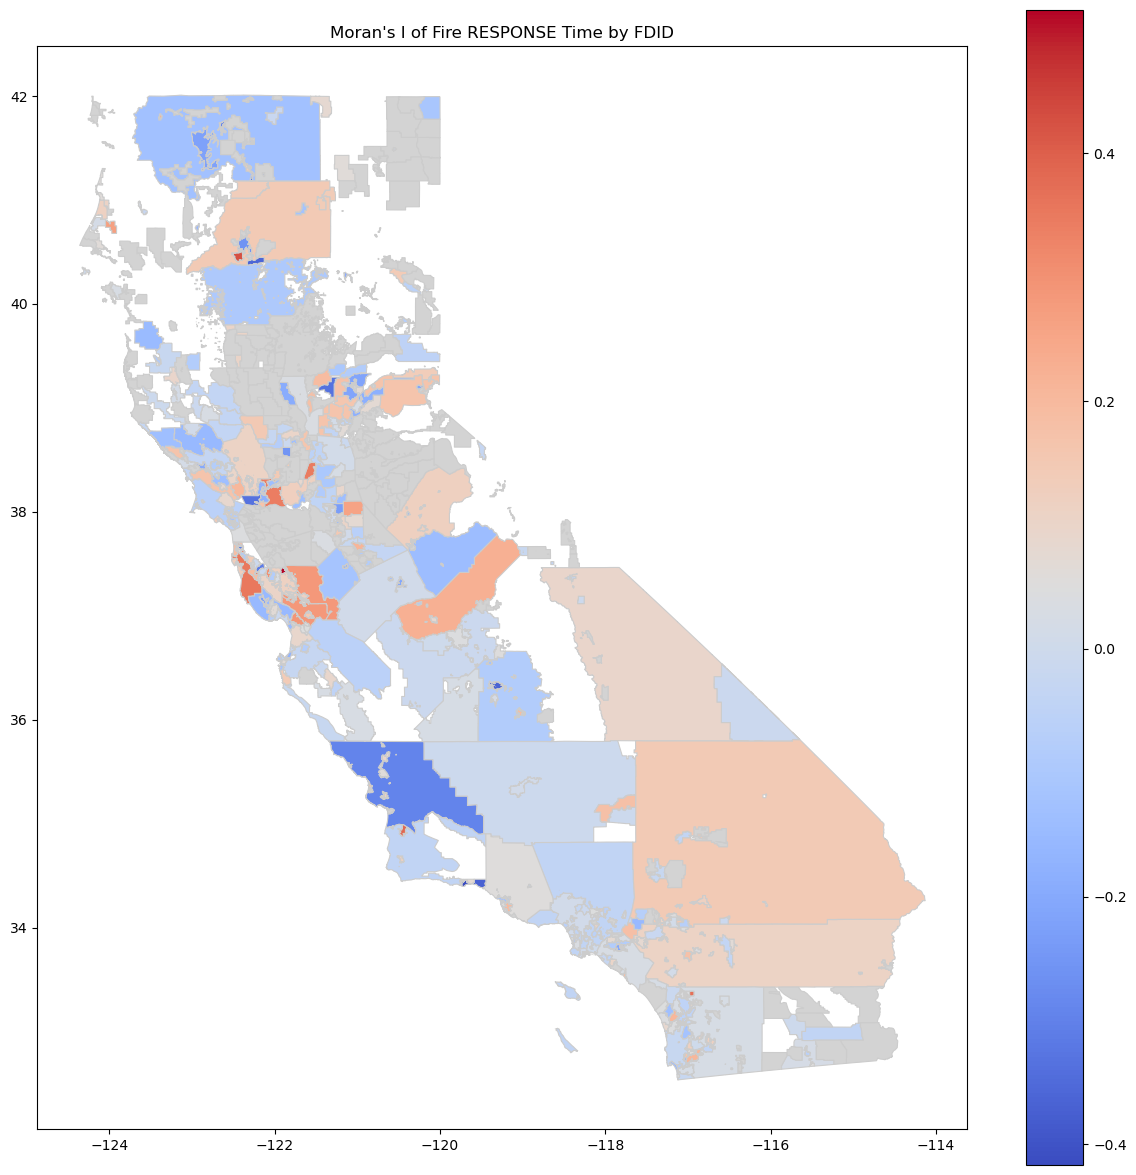

In [10]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 读取 Shapefile 文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 检查并设置 CRS 为 EPSG:4326
gdf = gdf.to_crs(epsg=4326)

# 读取保存的 Moran's I 结果
results_df = pd.read_csv('morans_data/2021/morans_i_results2021_rt.csv')

# 过滤掉包含空白 FDID 的行
results_df = results_df[results_df['FDID'].notna()]

# 将 FDID 转换为整数类型并再转换为字符串类型
results_df['FDID'] = results_df['FDID'].astype(int).astype(str)

# 检查合并前的数据
print(results_df.head())
print(gdf.head())

# 将 Moran's I 结果合并到 GeoDataFrame 中
gdf = gdf.merge(results_df, on='FDID', how='left')

# 检查合并后的数据
print(gdf.head())

# 绘制地图，展示 Moran's I 结果，设置缺失数据的颜色
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf.plot(column='Moran_I', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, 
         missing_kwds={"color": "lightgrey", "label": "No data"})
ax.set_title('Moran\'s I of Fire RESPONSE Time by FDID')
plt.show()


In [11]:
#============='FIRE_CLEARANCE_TIME'===============

In [3]:
import dask.dataframe as dd

# 使用Dask读取合并后的数据
merged_data_file = 'morans_data/2021/merged_fire_data_2021.csv'
merged = dd.read_csv(merged_data_file)

# 确保Dask dataframe中FDID是字符串类型
merged['FDID'] = merged['FDID'].astype(str)

# 显示前几行，确保数据正确读取
print(merged.head())


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   
1  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            6.0   
2  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
3  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   
4  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   

   FIRE_CLEARANCE_TIME  
0                 30.0  
1                  4.0  
2                 17.0  
3                 14.0  
4                  7.0  


In [4]:
# 为 FDID 生成一个索引
fdid_unique = merged['FDID'].unique().compute()
fdid_index = {fdid: idx for idx, fdid in enumerate(fdid_unique)}
merged['FDID_index'] = merged['FDID'].map(fdid_index)

# 显示前几行，确保索引正确生成
print(merged.head())


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   
1  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            6.0   
2  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
3  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   
4  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   

   FIRE_CLEARANCE_TIME  FDID_index  
0                 30.0           0  
1                  4.0           0  
2                 17.0           0  
3                 14.0           0  
4                  7.0           0  


In [5]:
import numpy as np
from libpysal.weights import DistanceBand
from esda.moran import Moran

# 定义计算 Moran's I 的函数
def compute_moran(chunk):
    fdid_index_values = chunk['FDID_index'].values
    y_response = chunk['FIRE_CLEARANCE_TIME'].values
    
    # 创建权重矩阵
    coords = np.array(list(enumerate(fdid_index_values)))
    w = DistanceBand(coords, threshold=1.5, binary=True, silence_warnings=True)
    
    moran_response = Moran(y_response, w)
    return moran_response.I, moran_response.p_norm


/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopython' keyw

In [6]:
# 分块计算 Moran's I
results = merged.map_partitions(compute_moran, meta=('I', 'f8')).compute()

# 显示计算结果
print(results)


0                                         (nan, nan)
1        (-0.004312056410166426, 0.9810592265621018)
2         (0.11069812936756666, 0.03783900795925453)
3         (0.1176909940346259, 0.027503302352621942)
4         (0.010786400257922575, 0.8010491095654112)
                            ...                     
1032    (-0.0018071921909932197, 0.9562291767661626)
1033      (0.10888342769560223, 0.13907207540566358)
1034     (-0.022560917912448044, 0.7691260351881886)
1035       (0.008977361485066839, 0.779589305323757)
1036      (0.006247515789602534, 0.7411244297685395)
Length: 1037, dtype: object


In [7]:
import pandas as pd
# 将结果转换为 DataFrame
results_df = pd.DataFrame(results.tolist(), columns=['Moran_I', 'p_value'])

# 添加 FDID 列
results_df['FDID'] = merged['FDID'].unique().compute()

# 保存结果到 CSV 文件
results_df.to_csv('morans_data/2021/morans_i_results2021_clear.csv', index=False)

In [8]:
# 过滤掉包含 nan 的结果
filtered_results = [res for res in results if not np.isnan(res[0]) and not np.isnan(res[1])]

# 检查是否有有效的结果
if filtered_results:
    # 计算总体的 Moran's I 平均值
    average_moran_i = np.mean([res[0] for res in filtered_results])
    average_p_value = np.mean([res[1] for res in filtered_results])

    # 输出结果
    print(f"Average Fire Clearance Time Moran's I: {average_moran_i}")
    print(f"Average Fire Clearance Time P-value: {average_p_value}")

    if average_p_value < 0.05:
        print("存在显著的火灾清除时间空间自相关")
    else:
        print("没有显著的火灾清除时间空间自相关")
else:
    print("所有分区的计算结果都包含 nan 值，无法计算总体的 Moran's I 平均值。")


Average Fire Clearance Time Moran's I: 0.0051389269781289375
Average Fire Clearance Time P-value: 0.5732899552339922
没有显著的火灾清除时间空间自相关


In [1]:
import geopandas as gpd

# 读取Shapefile文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保GeoDataFrame中FDID是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 显示前几行，确保数据正确读取
print(gdf.head())


    County   FDID MACSID                               Name  \
0  ALAMEDA    nan    NaN               CAMP PARKS FIRE DEPT   
1  ALAMEDA    nan    NaN  FAIRVIEW FIRE PROTECTION DISTRICT   
2  ALAMEDA  01005    ALA                         ALAMEDA FD   
3  ALAMEDA  01008    ACF                  ALAMEDA COUNTY FD   
4  ALAMEDA  01010    ALB                  CITY OF ALBANY FD   

              Address     City    Zip            FireChief           Phone  \
0                 NaN      NaN    NaN                  NaN             NaN   
1                 NaN      NaN    NaN                  NaN  (510) 583-4940   
2        1300 PARK ST  ALAMEDA  94501        NICHOLAS LUBY  (510) 337-2100   
3      6363 CLARK AVE   DUBLIN  94568  WILLIAM L. MCDONALD  (925) 833-3473   
4  1000 SAN PABLO AVE   ALBANY  94706          JAMES BOITO  (510) 528-5770   

  Notes  LastUpdate                                            Website  \
0   NaN  2018-06-21                                             <Null>   
1   

In [10]:
import dask.dataframe as dd
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights import DistanceBand
from esda.moran import Moran

# 使用 Dask 读取合并后的数据，这里包含response time
merged_data_file = 'morans_data/2021/merged_fire_data_2021.csv'
merged = dd.read_csv(merged_data_file)

# 确保 Dask DataFrame 中 FDID 是字符串类型
merged['FDID'] = merged['FDID'].astype(str)

# 读取 Shapefile 文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 检查并设置 CRS 为 EPSG:4326
gdf = gdf.to_crs(epsg=4326)


    Moran_I   p_value   FDID
0       NaN       NaN  10005
1 -0.004312  0.981059  10010
2  0.110698  0.037839  10030
3  0.117691  0.027503  10040
4  0.010786  0.801049  10045
    County   FDID MACSID                               Name  \
0  ALAMEDA    nan    NaN               CAMP PARKS FIRE DEPT   
1  ALAMEDA    nan    NaN  FAIRVIEW FIRE PROTECTION DISTRICT   
2  ALAMEDA  01005    ALA                         ALAMEDA FD   
3  ALAMEDA  01008    ACF                  ALAMEDA COUNTY FD   
4  ALAMEDA  01010    ALB                  CITY OF ALBANY FD   

              Address     City    Zip            FireChief           Phone  \
0                 NaN      NaN    NaN                  NaN             NaN   
1                 NaN      NaN    NaN                  NaN  (510) 583-4940   
2        1300 PARK ST  ALAMEDA  94501        NICHOLAS LUBY  (510) 337-2100   
3      6363 CLARK AVE   DUBLIN  94568  WILLIAM L. MCDONALD  (925) 833-3473   
4  1000 SAN PABLO AVE   ALBANY  94706          JAMES BOIT

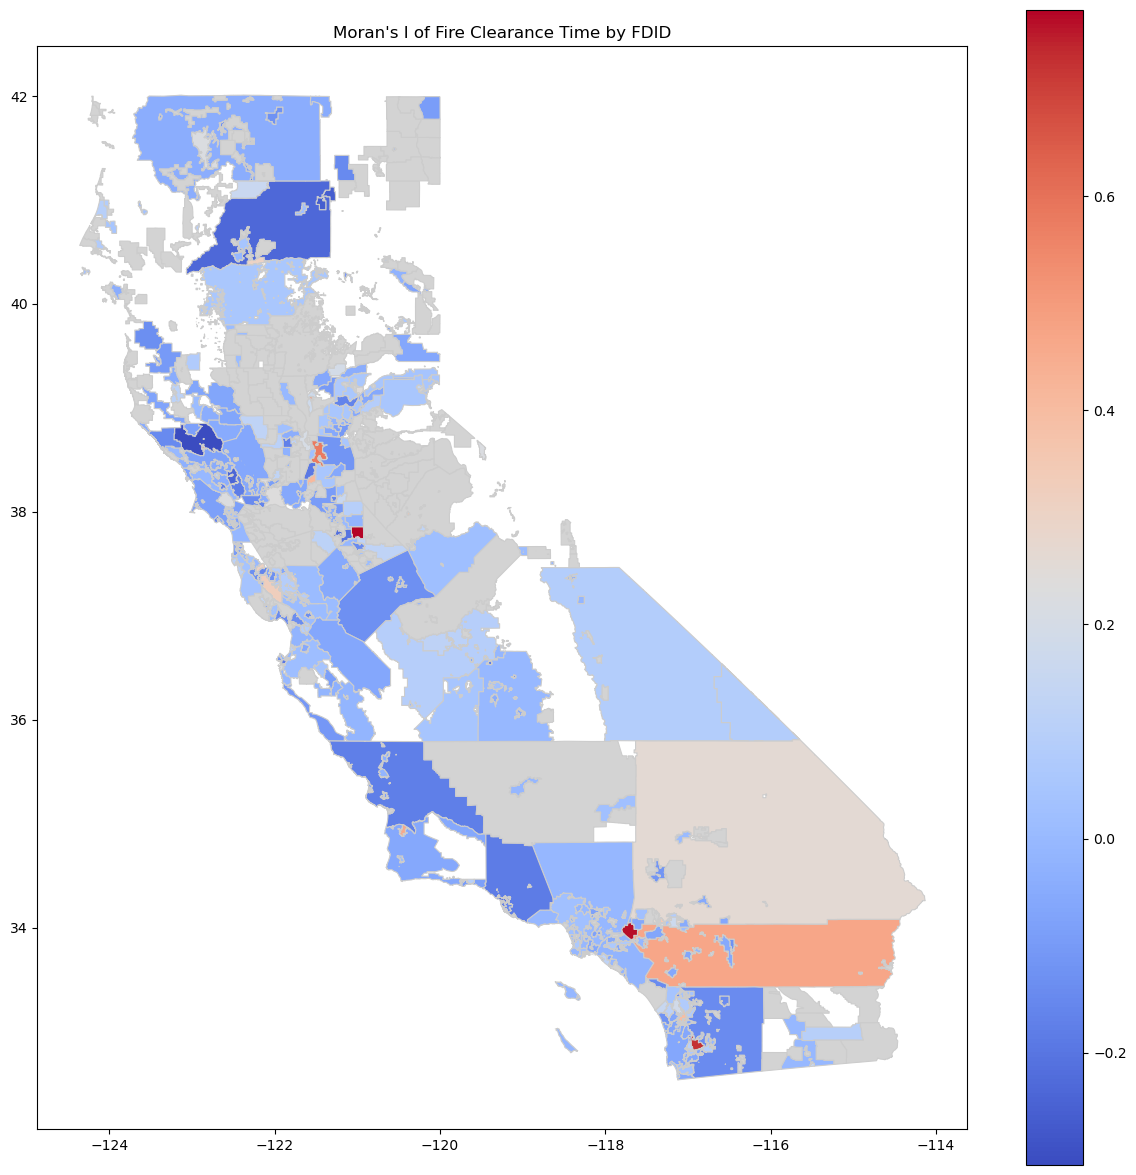

In [12]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 读取 Shapefile 文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 检查并设置 CRS 为 EPSG:4326
gdf = gdf.to_crs(epsg=4326)

# 读取保存的 Moran's I 结果
results_df = pd.read_csv('morans_data/2021/morans_i_results2021_clear.csv')

# 过滤掉包含空白 FDID 的行
results_df = results_df[results_df['FDID'].notna()]

# 将 FDID 转换为整数类型并再转换为字符串类型
results_df['FDID'] = results_df['FDID'].astype(int).astype(str)

# 检查合并前的数据
print(results_df.head())
print(gdf.head())

# 将 Moran's I 结果合并到 GeoDataFrame 中
gdf = gdf.merge(results_df, on='FDID', how='left')

# 检查合并后的数据
print(gdf.head())

# 绘制地图，展示 Moran's I 结果，设置缺失数据的颜色
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf.plot(column='Moran_I', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, 
         missing_kwds={"color": "lightgrey", "label": "No data"})
ax.set_title('Moran\'s I of Fire Clearance Time by FDID')
plt.show()


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 读取 Shapefile 文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 检查并设置 CRS 为 EPSG:4326
gdf = gdf.to_crs(epsg=4326)

# 读取保存的 Moran's I 结果
results_df = pd.read_csv('morans_data/2021/morans_i_results2021_clear.csv')

# 过滤掉包含空白 FDID 的行
results_df = results_df[results_df['FDID'].notna()]

# 将 FDID 转换为整数类型并再转换为字符串类型
results_df['FDID'] = results_df['FDID'].astype(int).astype(str)

# 检查合并前的数据
print(results_df.head())
print(gdf.head())

# 将 Moran's I 结果合并到 GeoDataFrame 中
gdf = gdf.merge(results_df, on='FDID', how='left')

# 检查合并后的数据
print(gdf.head())

# 绘制地图，展示 Moran's I 结果，设置缺失数据的颜色
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf.plot(column='Moran_I', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, 
         missing_kwds={"color": "lightgrey", "label": "No data"})
ax.set_title('Moran\'s I of Fire Clearance Time by FDID')
plt.show()


In [ ]:
#=================K-means==================

In [2]:
import dask.dataframe as dd
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

# 文件路径
filtered_data_file = 'morans_data/2021/filtered_fire_data_2021.csv'
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'

# 使用Dask读取火灾数据
fire_data_ca = dd.read_csv(filtered_data_file)
fire_data_ca['FDID'] = fire_data_ca['FDID'].astype(str)

# 读取shapefile数据
gdf = gpd.read_file(shapefile_path)
gdf['FDID'] = gdf['FDID'].astype(str)

# 将Dask DataFrame转换为Pandas DataFrame
fire_data_ca = fire_data_ca.compute()

# 合并数据
merged = gdf[['FDID', 'geometry']].merge(fire_data_ca, on='FDID', how='inner')

# 检查合并后的数据
print(merged.head())


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   
1  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            6.0   
2  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   
3  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   
4  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   

   FIRE_CLEARANCE_TIME  
0                 30.0  
1                  4.0  
2                 17.0  
3                 14.0  
4                  7.0  


In [3]:
# 选择要聚类的列
features = ['RESPONSE_TIME', 'FIRE_CLEARANCE_TIME']

# 标准化数据
scaler = StandardScaler()
data_scaled = scaler.fit_transform(merged[features])

# 检查标准化后的数据
print(data_scaled[:5])


[[-0.00963835 -0.01260298]
 [-0.00736058 -0.01835311]
 [-0.00849947 -0.01547804]
 [-0.00963835 -0.01614152]
 [-0.00849947 -0.01768963]]


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   
1  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            6.0   
2  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   
3  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   
4  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   

   FIRE_CLEARANCE_TIME  
0                 30.0  
1                  4.0  
2                 17.0  
3                 14.0  
4                  7.0  
[[-0.00962474 -0.01260298]
 [-0.0073479  -0.01835311]
 [-0.00848632 -0.01547804]
 [-0.00962474 -0.01614152]
 [-0.00848632 -0.01768963]]


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

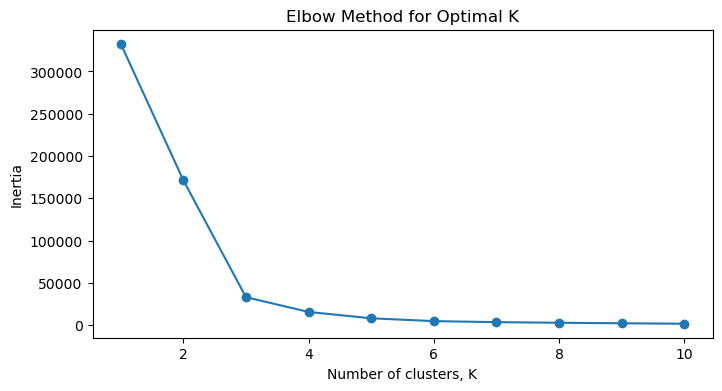

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   
1  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            6.0   
2  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   
3  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   
4  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   

   FIRE_CLEARANCE_TIME  Cluster  
0                 30.0        0  
1                  4.0        0  
2                 17.0        0  
3                 14.0        0  
4                  7.0        0  


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


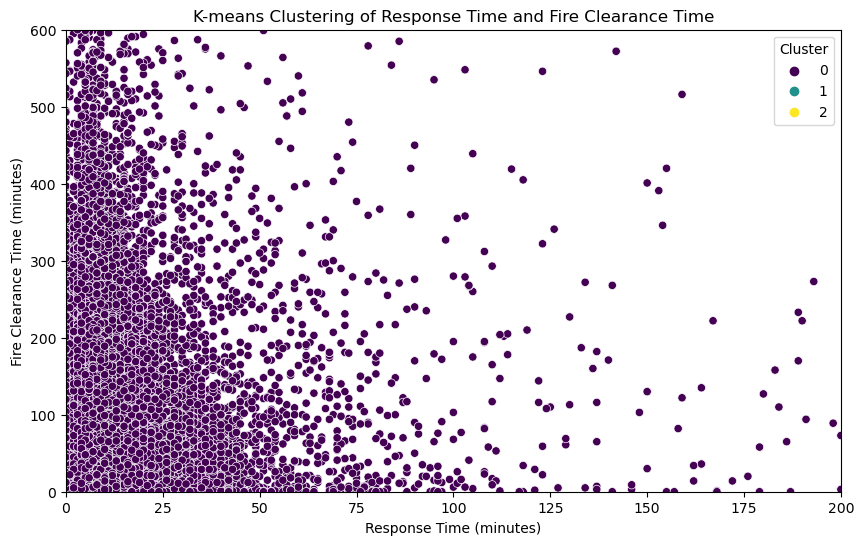

In [13]:
import dask.dataframe as dd
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

# 文件路径
filtered_data_file = 'morans_data/2021/filtered_fire_data_2021.csv'
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'

# 使用Dask读取火灾数据
fire_data_ca = dd.read_csv(filtered_data_file)
fire_data_ca['FDID'] = fire_data_ca['FDID'].astype(str)

# 读取shapefile数据
gdf = gpd.read_file(shapefile_path)
gdf['FDID'] = gdf['FDID'].astype(str)

# 将Dask DataFrame转换为Pandas DataFrame
fire_data_ca = fire_data_ca.compute()

# 合并数据
merged = gdf[['FDID', 'geometry']].merge(fire_data_ca, on='FDID', how='inner')

# 检查合并后的数据
print(merged.head())

# 删除包含缺失值的样本
merged = merged.dropna(subset=['RESPONSE_TIME', 'FIRE_CLEARANCE_TIME'])

# 选择要聚类的列
features = ['RESPONSE_TIME', 'FIRE_CLEARANCE_TIME']

# 标准化数据
scaler = StandardScaler()
data_scaled = scaler.fit_transform(merged[features])

# 检查标准化后的数据
print(data_scaled[:5])

# 使用Elbow方法选择K值
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# 可视化Elbow方法
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters, K')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# 应用K-means聚类 (假设选择的K值为3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# 将聚类结果添加到原始数据中
merged['Cluster'] = clusters

# 检查聚类结果
print(merged.head())

# 可视化聚类结果
plt.figure(figsize=(10, 6))
plt.gca().set_xlim([0,200])
plt.gca().set_ylim([0,600])
sns.scatterplot(x=merged['RESPONSE_TIME'], y=merged['FIRE_CLEARANCE_TIME'], hue=merged['Cluster'], palette='viridis')
plt.title('K-means Clustering of Response Time and Fire Clearance Time')
plt.xlabel('Response Time (minutes)')
plt.ylabel('Fire Clearance Time (minutes)')
plt.legend(title='Cluster')
plt.show()


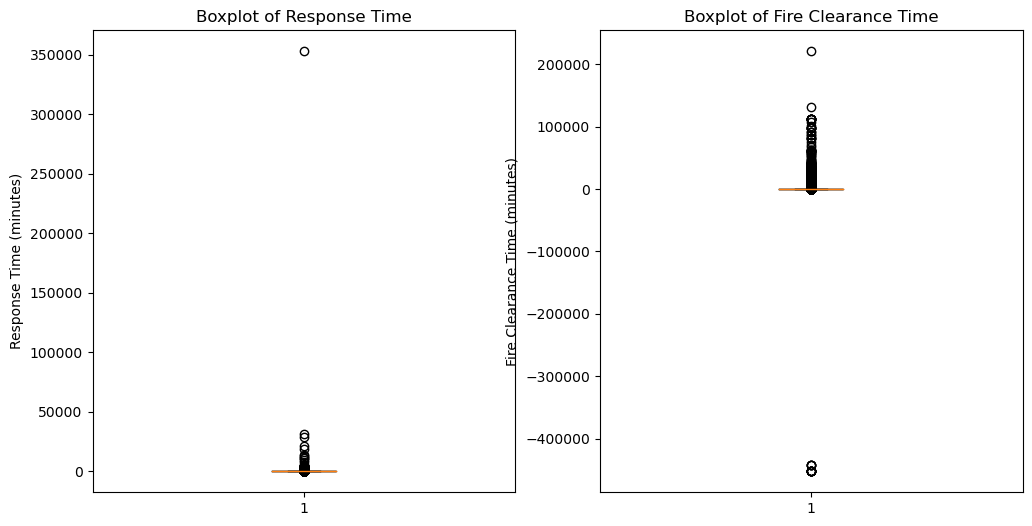

In [5]:
import matplotlib.pyplot as plt

# 绘制箱线图识别异常值
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.boxplot(merged['RESPONSE_TIME'])
plt.title('Boxplot of Response Time')
plt.ylabel('Response Time (minutes)')

plt.subplot(1, 2, 2)
plt.boxplot(merged['FIRE_CLEARANCE_TIME'])
plt.title('Boxplot of Fire Clearance Time')
plt.ylabel('Fire Clearance Time (minutes)')

plt.show()


In [6]:
# 定义删除异常值的函数
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# 删除响应时间和火灾清除时间中的异常值
merged_cleaned = remove_outliers(merged, 'RESPONSE_TIME')
merged_cleaned = remove_outliers(merged_cleaned, 'FIRE_CLEARANCE_TIME')

# 检查删除异常值后的数据
print(merged_cleaned.describe())


       RESPONSE_TIME  FIRE_CLEARANCE_TIME   Cluster
count  139652.000000        139652.000000  139652.0
mean        6.181687            20.306404       0.0
std         2.826717            18.832939       0.0
min         0.000000             0.000000       0.0
25%         4.000000             6.000000       0.0
50%         6.000000            14.000000       0.0
75%         8.000000            28.000000       0.0
max        14.000000            84.000000       0.0


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

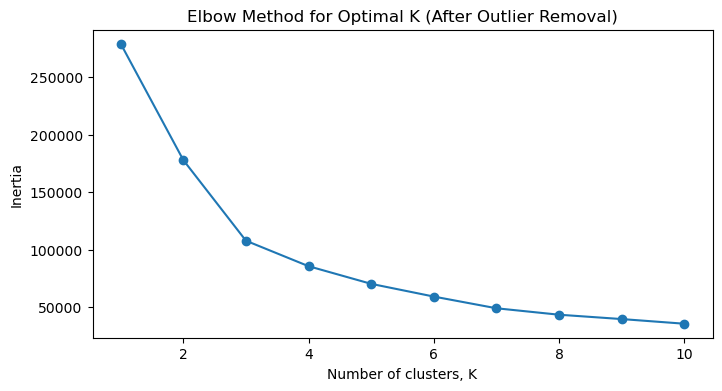

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   
1  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            6.0   
2  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   
3  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   
4  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   

   FIRE_CLEARANCE_TIME  Cluster  
0                 30.0        8  
1                  4.0        7  
2                 17.0        2  
3                 14.0        2  
4                  7.0        2  


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


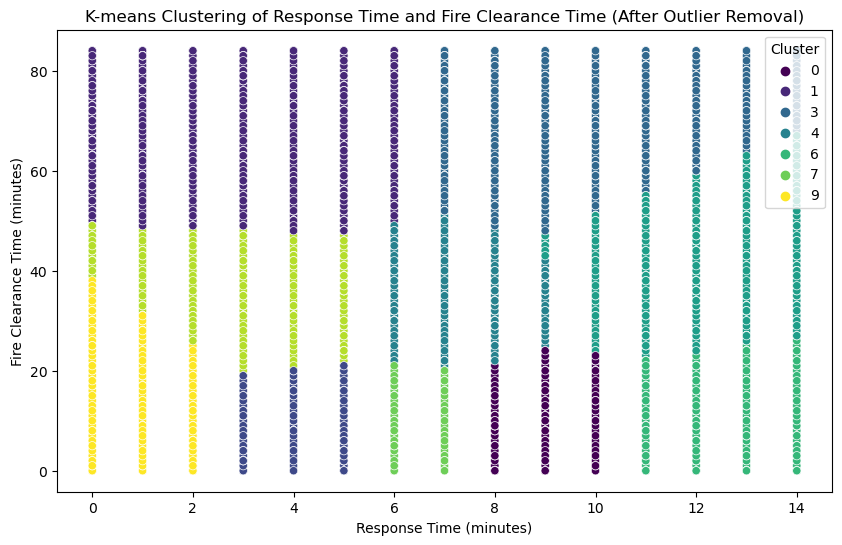

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

# 标准化数据
scaler = StandardScaler()
data_scaled_cleaned = scaler.fit_transform(merged_cleaned[features])

# 使用Elbow方法选择K值
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled_cleaned)
    inertia.append(kmeans.inertia_)

# 可视化Elbow方法
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters, K')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K (After Outlier Removal)')
plt.show()

# 应用K-means聚类 (假设选择的K值为3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled_cleaned)

# 将聚类结果添加到原始数据中
merged_cleaned['Cluster'] = clusters

# 检查聚类结果
print(merged_cleaned.head())

# 可视化聚类结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_cleaned['RESPONSE_TIME'], y=merged_cleaned['FIRE_CLEARANCE_TIME'], hue=merged_cleaned['Cluster'], palette='viridis')
plt.title('K-means Clustering of Response Time and Fire Clearance Time (After Outlier Removal)')
plt.xlabel('Response Time (minutes)')
plt.ylabel('Fire Clearance Time (minutes)')
plt.legend(title='Cluster')
plt.show()


/tmp/ipykernel_73418/2465456452.py:6: DtypeWarning: Columns (7,16,19,41) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(processed_csv_file)


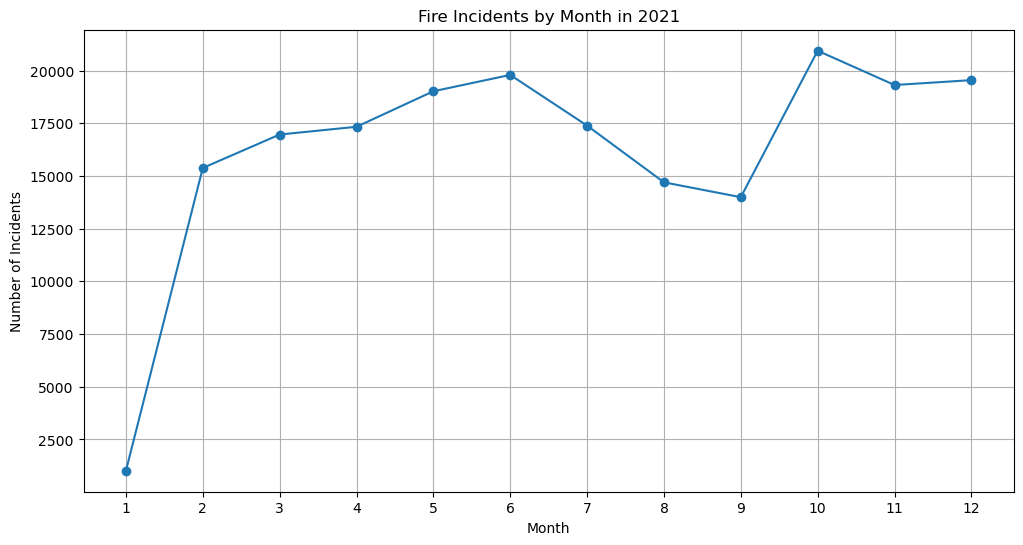

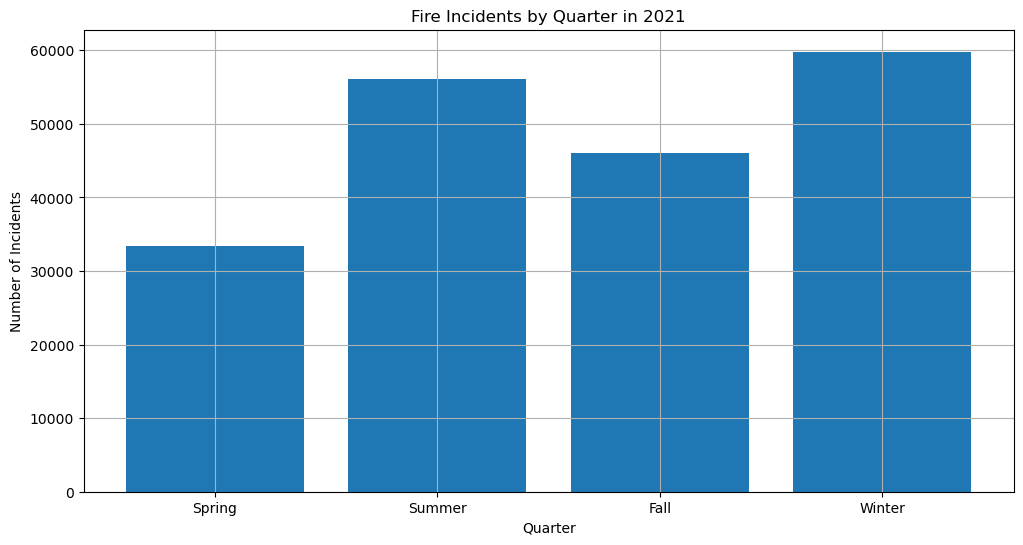

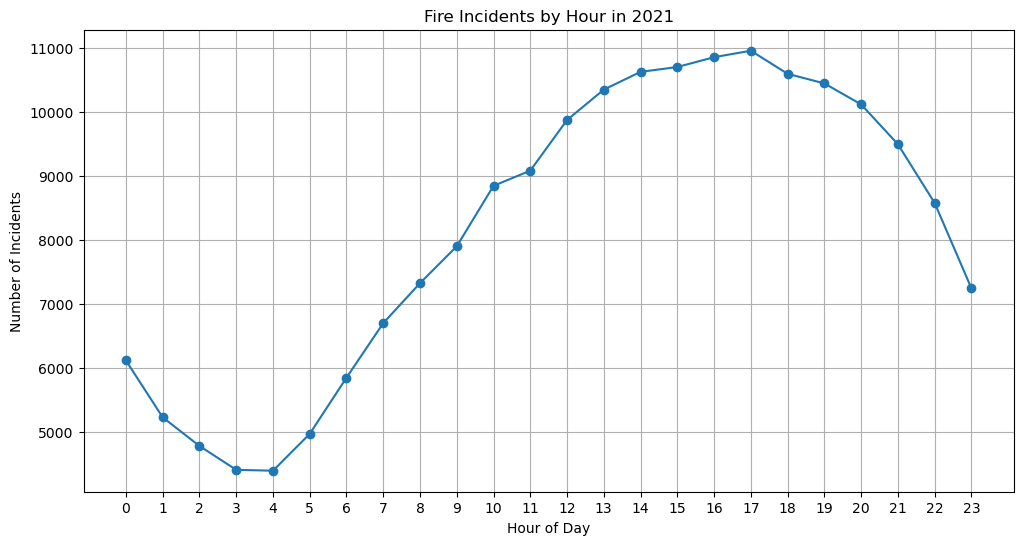

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取处理后的2021年火灾数据
processed_csv_file = 'morans_data/2021/basicincident_processed_2021.csv'
data = pd.read_csv(processed_csv_file)

# 提取时间特征
data['ALARM'] = pd.to_datetime(data['ALARM'], errors='coerce')
data['MONTH'] = data['ALARM'].dt.month
data['QUARTER'] = data['ALARM'].dt.quarter
data['HOUR'] = data['ALARM'].dt.hour

# 统计火灾事件数量
monthly_counts = data['MONTH'].value_counts().sort_index()
quarterly_counts = data['QUARTER'].value_counts().sort_index()
hourly_counts = data['HOUR'].value_counts().sort_index()

# 绘制火灾事件按月份分布图
plt.figure(figsize=(12, 6))
plt.plot(monthly_counts.index, monthly_counts.values, marker='o')
plt.title('Fire Incidents by Month in 2021')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

# 绘制火灾事件按季度分布图
plt.figure(figsize=(12, 6))
plt.bar(quarterly_counts.index, quarterly_counts.values)
plt.title('Fire Incidents by Quarter in 2021')
plt.xlabel('Quarter')
plt.ylabel('Number of Incidents')
plt.xticks([1, 2, 3, 4], ['Spring', 'Summer', 'Fall', 'Winter'])
plt.grid(True)
plt.show()

# 绘制火灾事件按小时分布图
plt.figure(figsize=(12, 6))
plt.plot(hourly_counts.index, hourly_counts.values, marker='o')
plt.title('Fire Incidents by Hour in 2021')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Incidents')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


    Moran_I   p_value   FDID
0  0.027339  0.424735  10005
1 -0.015421  0.820721  10010
2  0.045236  0.378260  10030
3 -0.001054  0.971475  10040
4  0.067301  0.199118  10045
    County   FDID MACSID                               Name  \
0  ALAMEDA    nan    NaN               CAMP PARKS FIRE DEPT   
1  ALAMEDA    nan    NaN  FAIRVIEW FIRE PROTECTION DISTRICT   
2  ALAMEDA  01005    ALA                         ALAMEDA FD   
3  ALAMEDA  01008    ACF                  ALAMEDA COUNTY FD   
4  ALAMEDA  01010    ALB                  CITY OF ALBANY FD   

              Address     City    Zip            FireChief           Phone  \
0                 NaN      NaN    NaN                  NaN             NaN   
1                 NaN      NaN    NaN                  NaN  (510) 583-4940   
2        1300 PARK ST  ALAMEDA  94501        NICHOLAS LUBY  (510) 337-2100   
3      6363 CLARK AVE   DUBLIN  94568  WILLIAM L. MCDONALD  (925) 833-3473   
4  1000 SAN PABLO AVE   ALBANY  94706          JAMES BOIT

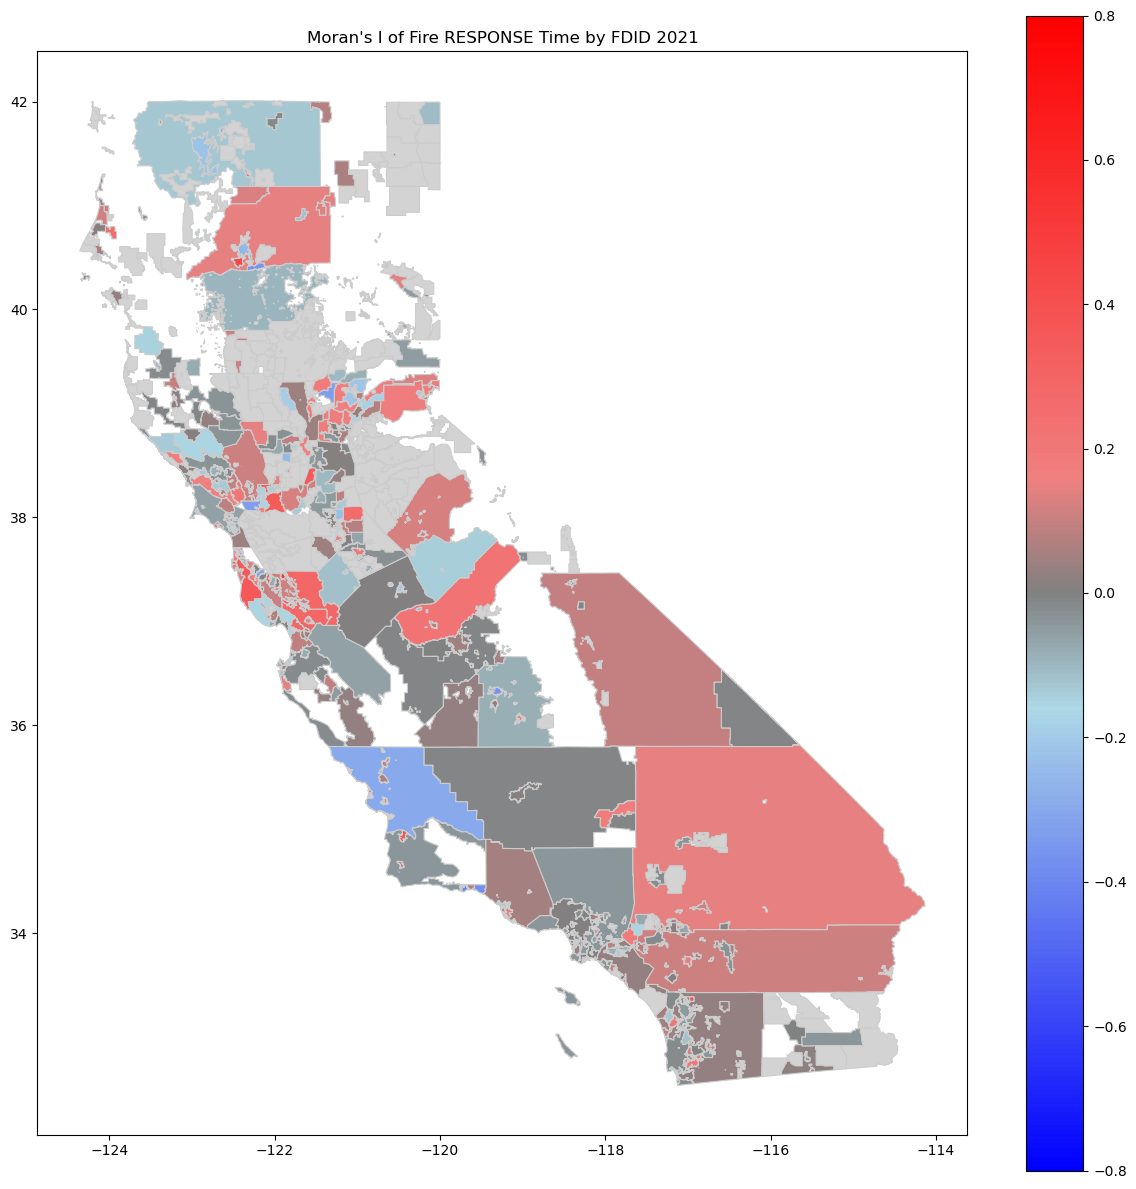

In [21]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

# 读取 Shapefile 文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 检查并设置 CRS 为 EPSG:4326
gdf = gdf.to_crs(epsg=4326)

# 读取保存的 Moran's I 结果
results_df = pd.read_csv('morans_data/2021/morans_i_results2021_rt.csv')

# 过滤掉包含空白 FDID 的行
results_df = results_df[results_df['FDID'].notna()]

# 将 FDID 转换为整数类型并再转换为字符串类型
results_df['FDID'] = results_df['FDID'].astype(int).astype(str)

# 检查合并前的数据
print(results_df.head())
print(gdf.head())

# 将 Moran's I 结果合并到 GeoDataFrame 中
gdf = gdf.merge(results_df, on='FDID', how='left')

# 检查合并后的数据
print(gdf.head())

# 自定义颜色映射器，增加颜色的区分度
colors = [
    (0, "blue"),     # 负数部分
    (0.4, "lightblue"),
    (0.5, "gray"),   # 0 对应灰色
    (0.6, "lightcoral"),
    (1, "red")       # 正数部分
]

cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# 绘制地图，展示 Moran's I 结果，设置缺失数据的颜色
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf.plot(column='Moran_I', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, 
         vmin=-0.8, vmax=0.8,  # 设置颜色范围
         missing_kwds={"color": "lightgrey", "label": "No data"})
ax.set_title('Moran\'s I of Fire RESPONSE Time by FDID 2021')
plt.show()


    Moran_I   p_value   FDID
0       NaN       NaN  10005
1 -0.004312  0.981059  10010
2  0.110698  0.037839  10030
3  0.117691  0.027503  10040
4  0.010786  0.801049  10045
    County   FDID MACSID                               Name  \
0  ALAMEDA    nan    NaN               CAMP PARKS FIRE DEPT   
1  ALAMEDA    nan    NaN  FAIRVIEW FIRE PROTECTION DISTRICT   
2  ALAMEDA  01005    ALA                         ALAMEDA FD   
3  ALAMEDA  01008    ACF                  ALAMEDA COUNTY FD   
4  ALAMEDA  01010    ALB                  CITY OF ALBANY FD   

              Address     City    Zip            FireChief           Phone  \
0                 NaN      NaN    NaN                  NaN             NaN   
1                 NaN      NaN    NaN                  NaN  (510) 583-4940   
2        1300 PARK ST  ALAMEDA  94501        NICHOLAS LUBY  (510) 337-2100   
3      6363 CLARK AVE   DUBLIN  94568  WILLIAM L. MCDONALD  (925) 833-3473   
4  1000 SAN PABLO AVE   ALBANY  94706          JAMES BOIT

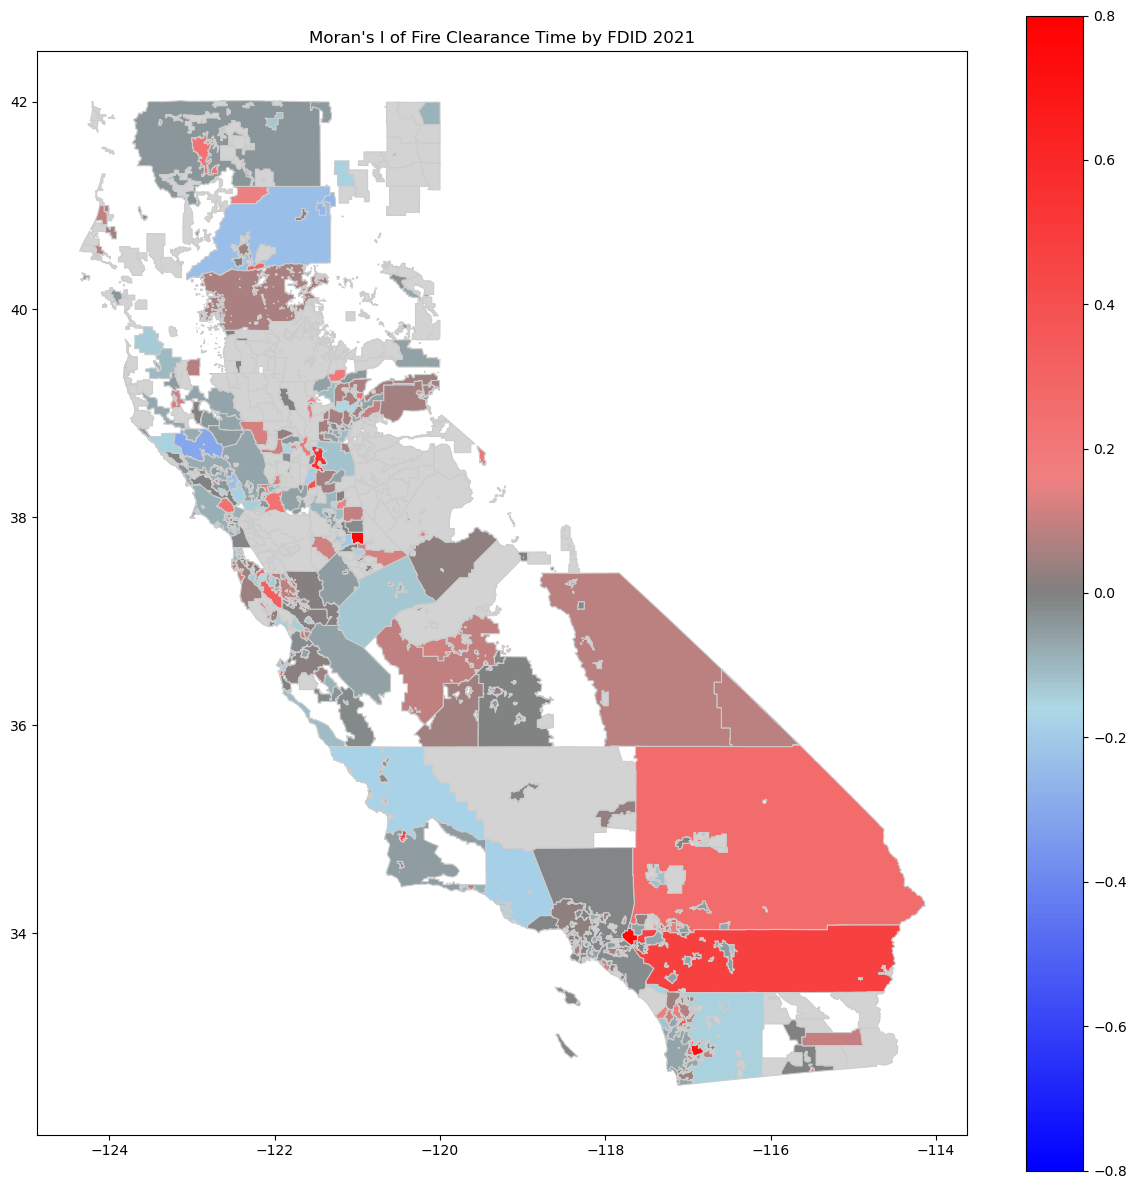

In [20]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

# 读取 Shapefile 文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 检查并设置 CRS 为 EPSG:4326
gdf = gdf.to_crs(epsg=4326)

# 读取保存的 Moran's I 结果
results_df = pd.read_csv('morans_data/2021/morans_i_results2021_clear.csv')

# 过滤掉包含空白 FDID 的行
results_df = results_df[results_df['FDID'].notna()]

# 将 FDID 转换为整数类型并再转换为字符串类型
results_df['FDID'] = results_df['FDID'].astype(int).astype(str)

# 检查合并前的数据
print(results_df.head())
print(gdf.head())

# 将 Moran's I 结果合并到 GeoDataFrame 中
gdf = gdf.merge(results_df, on='FDID', how='left')

# 检查合并后的数据
print(gdf.head())

# 自定义颜色映射器，增加颜色的区分度
colors = [
    (0, "blue"),     # 负数部分
    (0.4, "lightblue"),
    (0.5, "gray"),   # 0 对应灰色
    (0.6, "lightcoral"),
    (1, "red")       # 正数部分
]

cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# 绘制地图，展示 Moran's I 结果，设置缺失数据的颜色
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf.plot(column='Moran_I', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, 
         vmin=-0.8, vmax=0.8,  # 设置颜色范围
         missing_kwds={"color": "lightgrey", "label": "No data"})
ax.set_title('Moran\'s I of Fire Clearance Time by FDID 2021')
plt.show()


    Moran_I   p_value   FDID
0  0.123797  0.000427  10005
1  0.074483  0.157004  10010
2  0.028452  0.565565  10020
3 -0.038567  0.516133  10030
4  0.096048  0.070050  10040
    County   FDID MACSID                               Name  \
0  ALAMEDA    nan    NaN               CAMP PARKS FIRE DEPT   
1  ALAMEDA    nan    NaN  FAIRVIEW FIRE PROTECTION DISTRICT   
2  ALAMEDA  01005    ALA                         ALAMEDA FD   
3  ALAMEDA  01008    ACF                  ALAMEDA COUNTY FD   
4  ALAMEDA  01010    ALB                  CITY OF ALBANY FD   

              Address     City    Zip            FireChief           Phone  \
0                 NaN      NaN    NaN                  NaN             NaN   
1                 NaN      NaN    NaN                  NaN  (510) 583-4940   
2        1300 PARK ST  ALAMEDA  94501        NICHOLAS LUBY  (510) 337-2100   
3      6363 CLARK AVE   DUBLIN  94568  WILLIAM L. MCDONALD  (925) 833-3473   
4  1000 SAN PABLO AVE   ALBANY  94706          JAMES BOIT

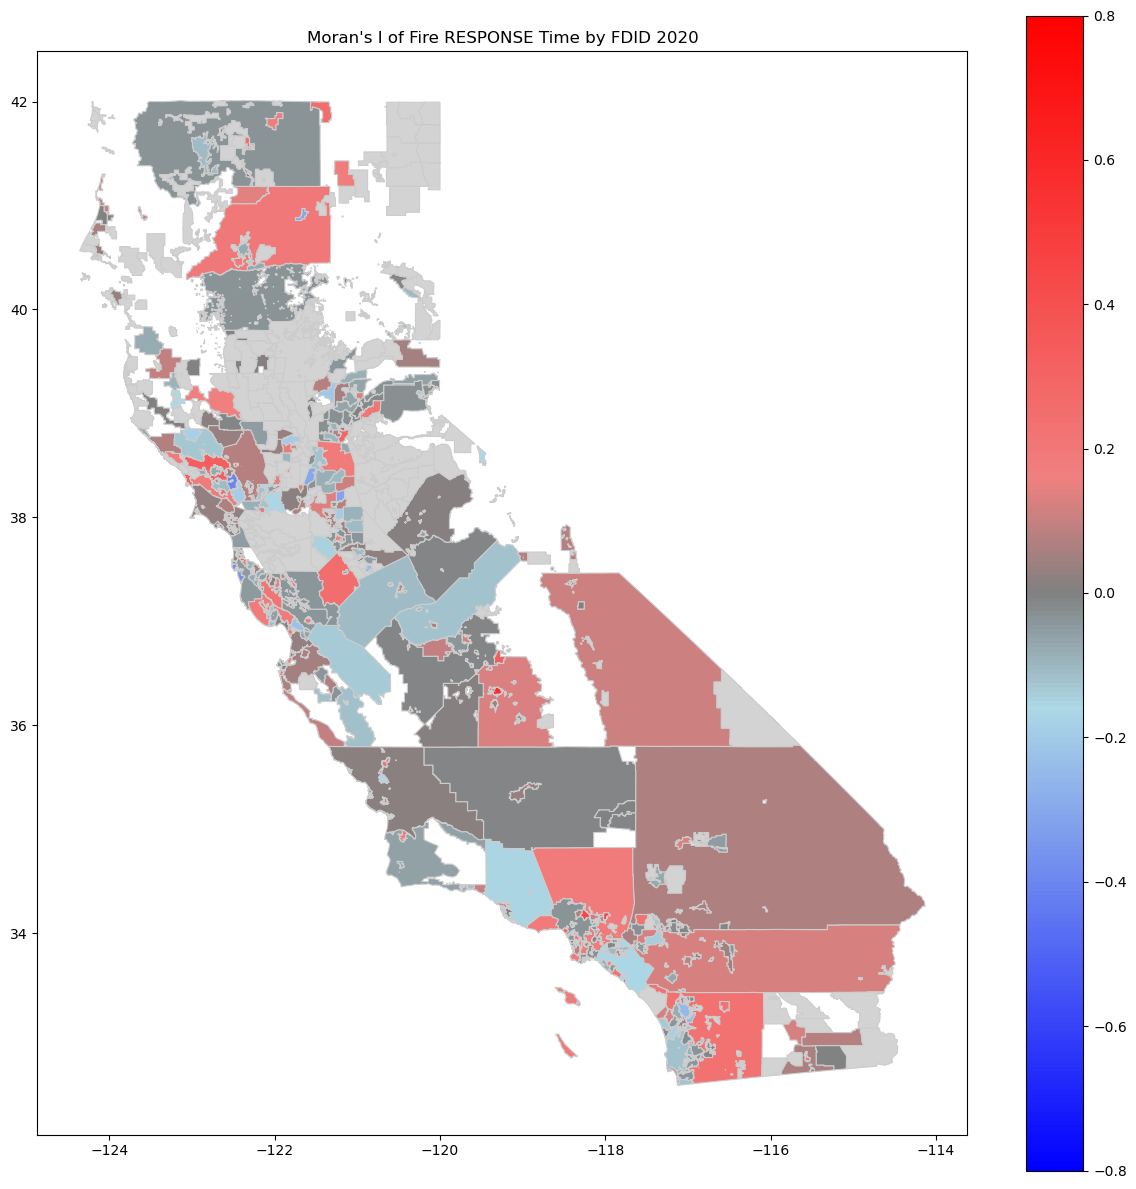

In [22]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

# 读取 Shapefile 文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 检查并设置 CRS 为 EPSG:4326
gdf = gdf.to_crs(epsg=4326)

# 读取保存的 Moran's I 结果
results_df = pd.read_csv('morans_data/2020/morans_i_results2020_rt.csv')

# 过滤掉包含空白 FDID 的行
results_df = results_df[results_df['FDID'].notna()]

# 将 FDID 转换为整数类型并再转换为字符串类型
results_df['FDID'] = results_df['FDID'].astype(int).astype(str)

# 检查合并前的数据
print(results_df.head())
print(gdf.head())

# 将 Moran's I 结果合并到 GeoDataFrame 中
gdf = gdf.merge(results_df, on='FDID', how='left')

# 检查合并后的数据
print(gdf.head())

# 自定义颜色映射器，增加颜色的区分度
colors = [
    (0, "blue"),     # 负数部分
    (0.4, "lightblue"),
    (0.5, "gray"),   # 0 对应灰色
    (0.6, "lightcoral"),
    (1, "red")       # 正数部分
]

cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# 绘制地图，展示 Moran's I 结果，设置缺失数据的颜色
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf.plot(column='Moran_I', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, 
         vmin=-0.8, vmax=0.8,  # 设置颜色范围
         missing_kwds={"color": "lightgrey", "label": "No data"})
ax.set_title('Moran\'s I of Fire RESPONSE Time by FDID 2020')
plt.show()


    Moran_I   p_value   FDID
0       NaN       NaN  10005
1 -0.099937  0.076717  10010
2 -0.006641  0.947155  10020
3 -0.007593  0.933328  10030
4  0.099022  0.062042  10040
    County   FDID MACSID                               Name  \
0  ALAMEDA    nan    NaN               CAMP PARKS FIRE DEPT   
1  ALAMEDA    nan    NaN  FAIRVIEW FIRE PROTECTION DISTRICT   
2  ALAMEDA  01005    ALA                         ALAMEDA FD   
3  ALAMEDA  01008    ACF                  ALAMEDA COUNTY FD   
4  ALAMEDA  01010    ALB                  CITY OF ALBANY FD   

              Address     City    Zip            FireChief           Phone  \
0                 NaN      NaN    NaN                  NaN             NaN   
1                 NaN      NaN    NaN                  NaN  (510) 583-4940   
2        1300 PARK ST  ALAMEDA  94501        NICHOLAS LUBY  (510) 337-2100   
3      6363 CLARK AVE   DUBLIN  94568  WILLIAM L. MCDONALD  (925) 833-3473   
4  1000 SAN PABLO AVE   ALBANY  94706          JAMES BOIT

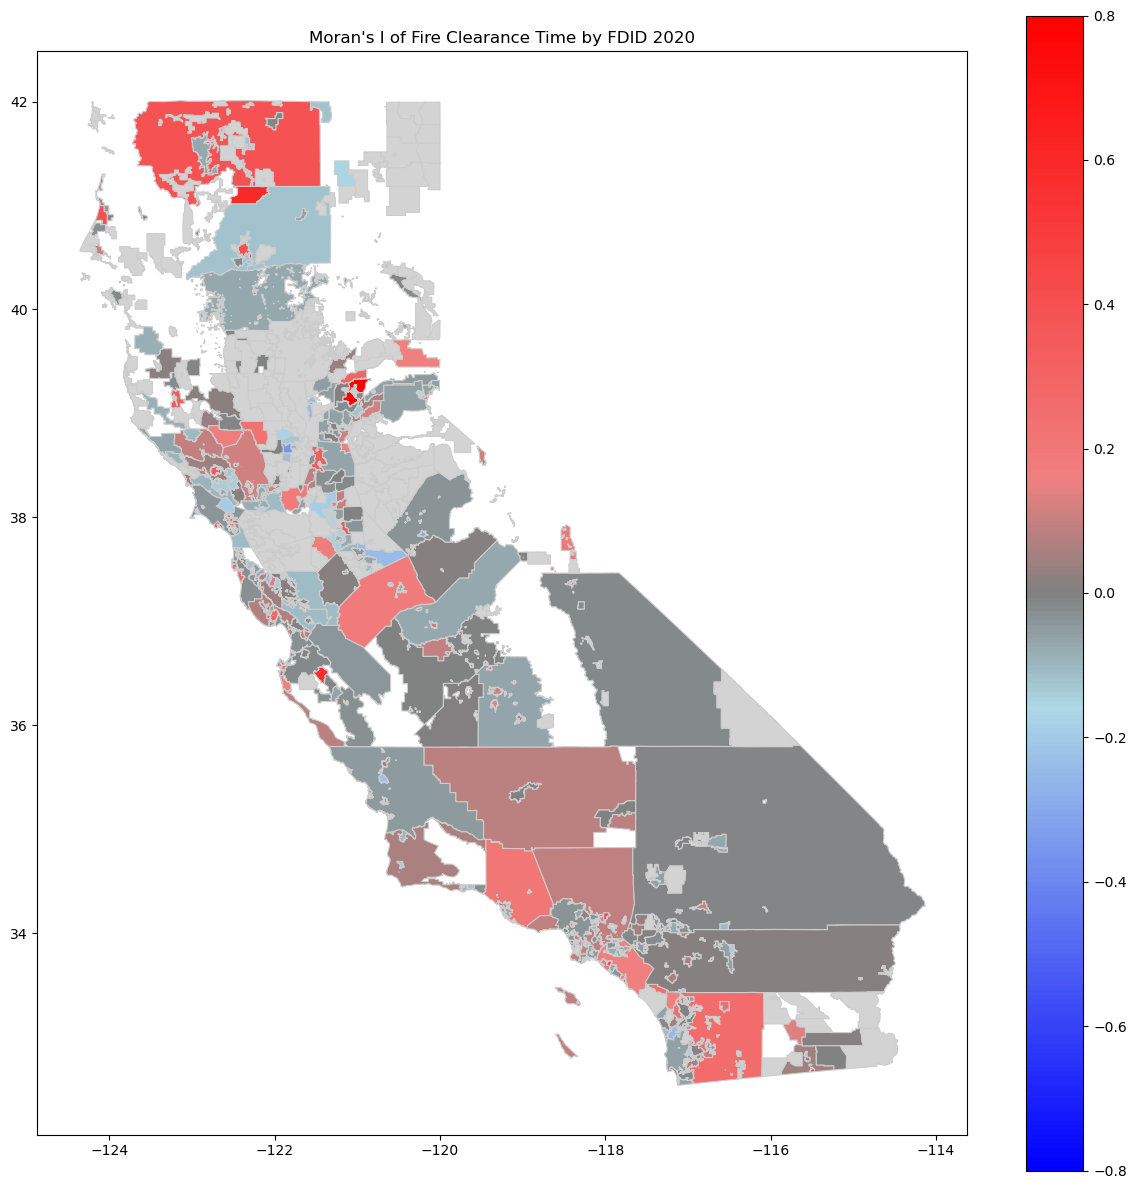

In [23]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

# 读取 Shapefile 文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 检查并设置 CRS 为 EPSG:4326
gdf = gdf.to_crs(epsg=4326)

# 读取保存的 Moran's I 结果
results_df = pd.read_csv('morans_data/2020/morans_i_results2020_clear.csv')

# 过滤掉包含空白 FDID 的行
results_df = results_df[results_df['FDID'].notna()]

# 将 FDID 转换为整数类型并再转换为字符串类型
results_df['FDID'] = results_df['FDID'].astype(int).astype(str)

# 检查合并前的数据
print(results_df.head())
print(gdf.head())

# 将 Moran's I 结果合并到 GeoDataFrame 中
gdf = gdf.merge(results_df, on='FDID', how='left')

# 检查合并后的数据
print(gdf.head())

# 自定义颜色映射器，增加颜色的区分度
colors = [
    (0, "blue"),     # 负数部分
    (0.4, "lightblue"),
    (0.5, "gray"),   # 0 对应灰色
    (0.6, "lightcoral"),
    (1, "red")       # 正数部分
]

cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# 绘制地图，展示 Moran's I 结果，设置缺失数据的颜色
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf.plot(column='Moran_I', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, 
         vmin=-0.8, vmax=0.8,  # 设置颜色范围
         missing_kwds={"color": "lightgrey", "label": "No data"})
ax.set_title('Moran\'s I of Fire Clearance Time by FDID 2020')
plt.show()
